In [1]:
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from io import StringIO # Python3 use: from io import StringIO
import sys
from utils.wrapper import *
#from utils.diagnostics import *
%matplotlib notebook
np.set_printoptions(formatter={'float': lambda x: "{0:5.3f}".format(x)})

to do : 
    1. test more functions
    2. try one-step line search
    3. plot grid of convergence
    
    ** refactor the code of library

In [32]:
def draw_ellipse(self, ax, mean, var_half):
    eigVal_sqrt = np.linalg.norm(var_half, ord=2, axis=(0))
    eigVec = var_half / eigVal_sqrt
    width, height = 2 * 3 * eigVal_sqrt
    angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
    e1 = patches.Ellipse(mean, width, height,
                         angle=-angle, linewidth=2, fill=False, zorder=2)
    ax.add_patch(e1)
    ax.scatter(mean[0], mean[1], c='black', s=15)
    
def setup_scatter(self, ax, i):
    '''
    set up the plot of CMA-ES candidates at i-th iteration
    '''
    # draw x-axis and y-axis
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draw the position of optimal 
    ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
    # draw the trail of local minimum
    if self.trail:
        ax.scatter(self.trail[0], self.trail[1], c='red', s=11)
    # draw candidates on scatter plot
    ax.set_xlim(np.min(self.arg[:,:,0]), np.max(self.arg[:,:,0]))
    ax.set_ylim(np.min(self.arg[:,:,1]), np.max(self.arg[:,:,1]))
    p = sns.scatterplot(x=self.arg[i,:,0], y=self.arg[i,:,1], color="r", hue=i, hue_norm=(0, self.val.shape[0]), legend=False)
    # draw ellipse representing 3 sigma areas of normal distribution
    self.draw_ellipse(ax, self.stats['mean'][i], self.stats['var'][i])
    
def animate_moving_cluster(self):
    def animate(i):
        plt.clf()
        ax = fig.add_subplot(1, 1, 1)    
        ax.set_title('iter=%d' % (i+1))
        self.setup_scatter(ax, i+1)
    fig = plt.figure(figsize=(8,4))
    ani = animation.FuncAnimation(fig, animate, frames=self.arg.shape[0], repeat=False, interval=500)
    return ani

def animate_scatterplot_distance(self):
    def animate(i):
        plt.clf()
        # draw scatter and ellipse
        ax0 = fig.add_subplot(2, 1, 1)
        ax0.set_title('iter=%d, func_dist=%.1f,  arg_distance=%.1f, mean=(%.3f, %.3f)' % (i+1, self.distance_val[i+1], self.distance_arg[i+1], \
                                    self.stats['mean'][i+1,0], self.stats['mean'][i+1,1]))
        self.setup_scatter(ax0, i+1)
        # plot distance
        ax1 = fig.add_subplot(2, 1, 2)
        self.plot_distance_common(ax1, i)
    self.get_distance()
    fig = plt.figure(figsize=(8,4))
    ani = animation.FuncAnimation(fig, animate, frames=self.val.shape[0], repeat=False, interval=500)
    return ani

non_convex_optimisation.animate_moving_cluster = animate_moving_cluster
non_convex_optimisation.animate_scatterplot_distance = animate_scatterplot_distance
non_convex_optimisation.setup_scatter = setup_scatter
non_convex_optimisation.draw_ellipse = draw_ellipse

# tested objective function

In [3]:
def bukin(x):
    '''
    non-disappearing gradient
    large gradient and uncontinuous gradient around ridge/local optimal
    optimum: 0
    optimal: (-10, 1)
    '''
    return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2)) + 0.01 * np.abs(x[0] + 10)
def bukin_first(x):
    return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2))
def bukin_second(x):
    return 0.01 * np.abs(x[0] + 10)
def bukin_second_strong(x):
    return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2)) + 100 * np.abs(x[0] + 10)

def d_bukin(x):
    arg1 = x[1] - 0.01 * x[0]**2
    arg2 = 1 / np.sqrt(np.abs(arg1)) if arg1 != 0 else 0
    return np.array([- np.sign(arg1) * x[1] * arg2 + 0.01 * np.sign(x[0] + 10), 50 * np.sign(arg1) * arg2])

# Visualisation tool

In [24]:
def plot_scatter(func, lim, N):
    x, y = np.linspace(-lim, lim, N), np.linspace(-lim, lim, N)
    xx, yy = np.meshgrid(x, y)
    zz = np.zeros(xx.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            zz[i, j] = func([x[i], y[j]])
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.scatter(x=xx.ravel(), y=yy.ravel(),c=zz.ravel())
    fig.show()
    
def plot_surface(func, lim, N):
    x, y = np.linspace(-lim, lim, N), np.linspace(-lim, lim, N)
    z = []
    for i in x:
        z_line = []
        for j in y:
            z_line.append(func([i,j]))
        z.append(z_line)

    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

<IPython.core.display.Javascript object>


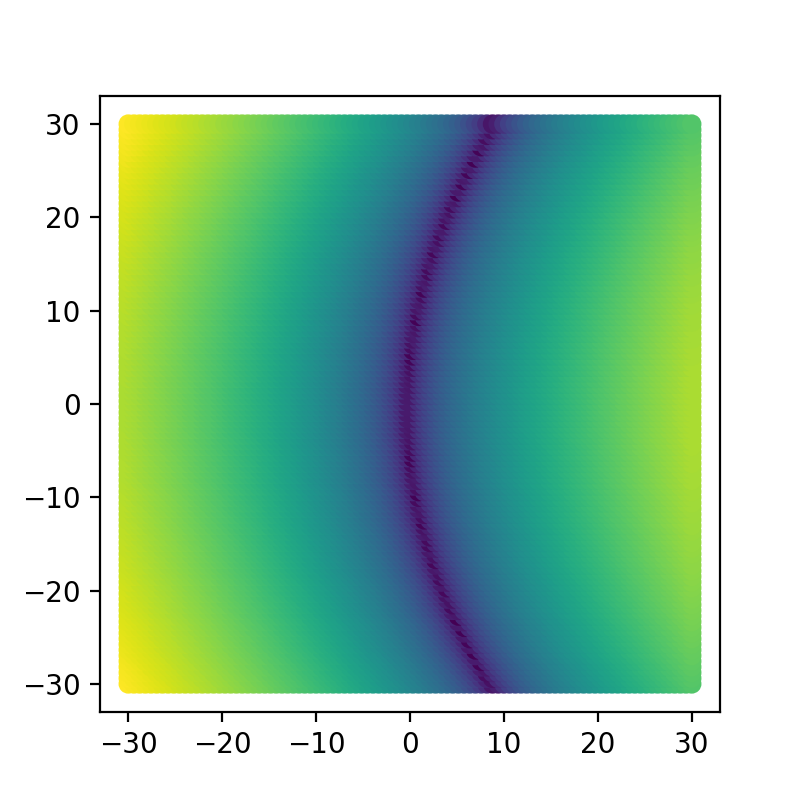

In [25]:
N = 100
lim = 30
plot_scatter(bukin, lim, N)

In [35]:
plot_surface(bukin, lim, N)

## first part of bukin

In [74]:
plot_surface(bukin_first, lim, N)

## second part of bukin

In [75]:
plot_surface(bukin_second, lim, N)

# numerical experiments

### sample some points from a square areas,  used as initial mean later

In [4]:
def sample_from_square(edge, center, num):
    rx = (np.random.rand(num) - 0.5) * 2 * edge[0] - center[0] / 2
    ry = (np.random.rand(num) - 0.5) * 2 * edge[1] - center[1] / 2
    return np.array([rx, ry]).reshape(num, 2)

In [5]:
np.random.seed(19)
points = sample_from_square(np.array([100,100]),  np.array([0, 0]), 50)

### ridge where local minimas distributed 

In [6]:
x = np.linspace(-50, 50, 201)
parabola = lambda x: 0.01 * x**2
y = parabola(x)
ridge = (x, y)

## original CMA

- initial mean $$ \left( \begin{array}{cc} -21.9 & 10 \end{array}\right) $$
- initial variance
$$ \left( \begin{array}{cc} 0.003^2 & 0 \\ 0 & 0.003^2 \end{array}\right) $$

In [30]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 1
beta = 2
np.random.seed(101)
optimal = np.array([-10,1])
optimum = 0


ex1 = non_convex_optimisation(bukin, d_bukin, optimal, optimum, ridge)
ex1.do_experiments(mean0, sigma, alpha, beta, do_nothing)

*******starting soon, intitial mean: ********
 [[-21.900]
 [10.000]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 0.17392309611224796, total iterations = 400, total evaluatios = 2400
 position = 0.0007207584762464313 3.2345125005801226e-07



In [8]:
val, arg, stats = ex1.get_recorded_data()

<IPython.core.display.Javascript object>


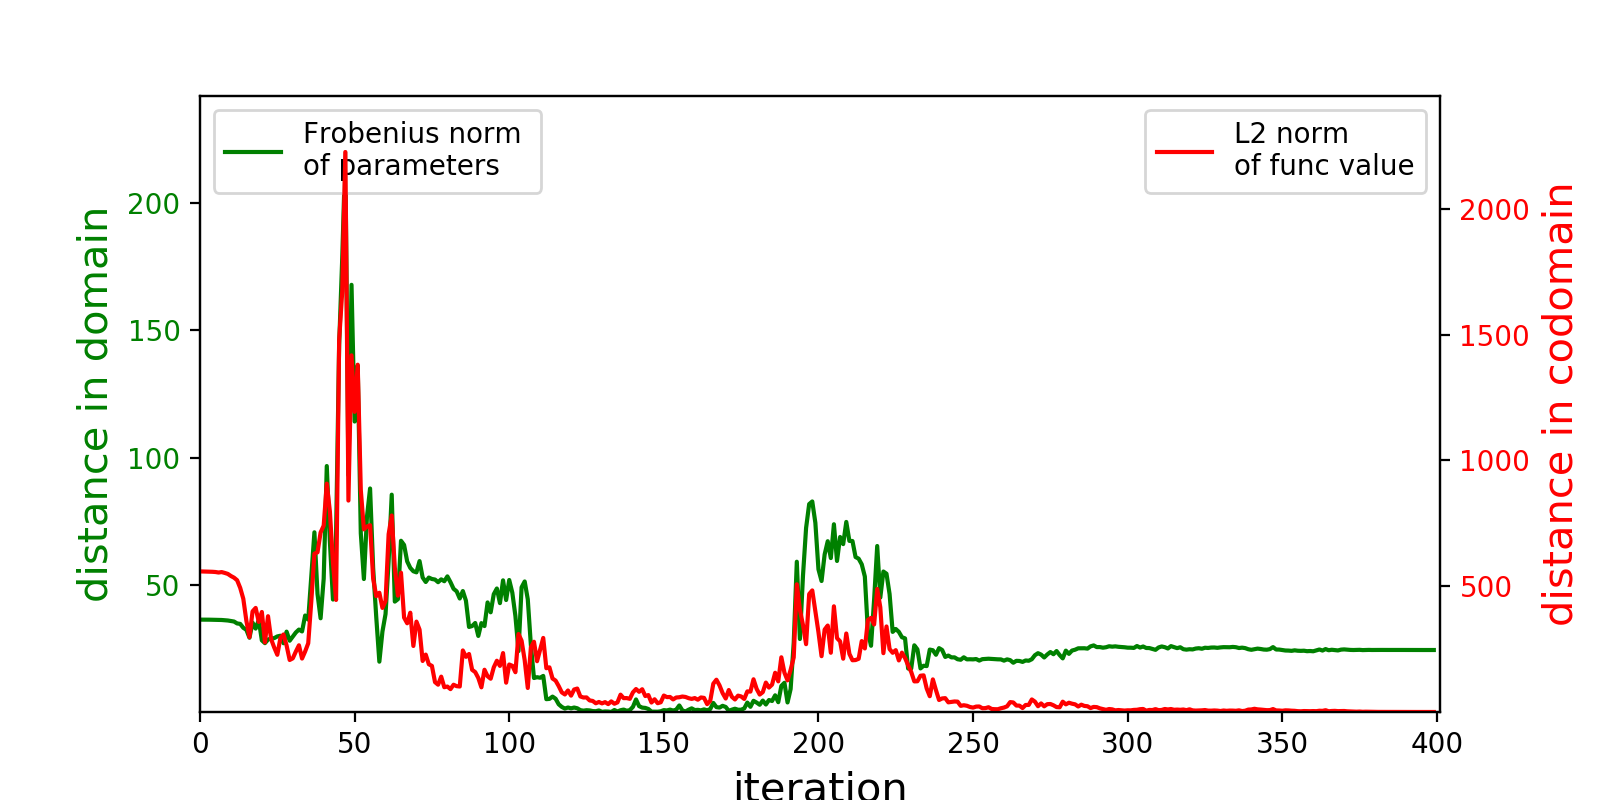

In [18]:
ex1.plot_distance()

<IPython.core.display.Javascript object>


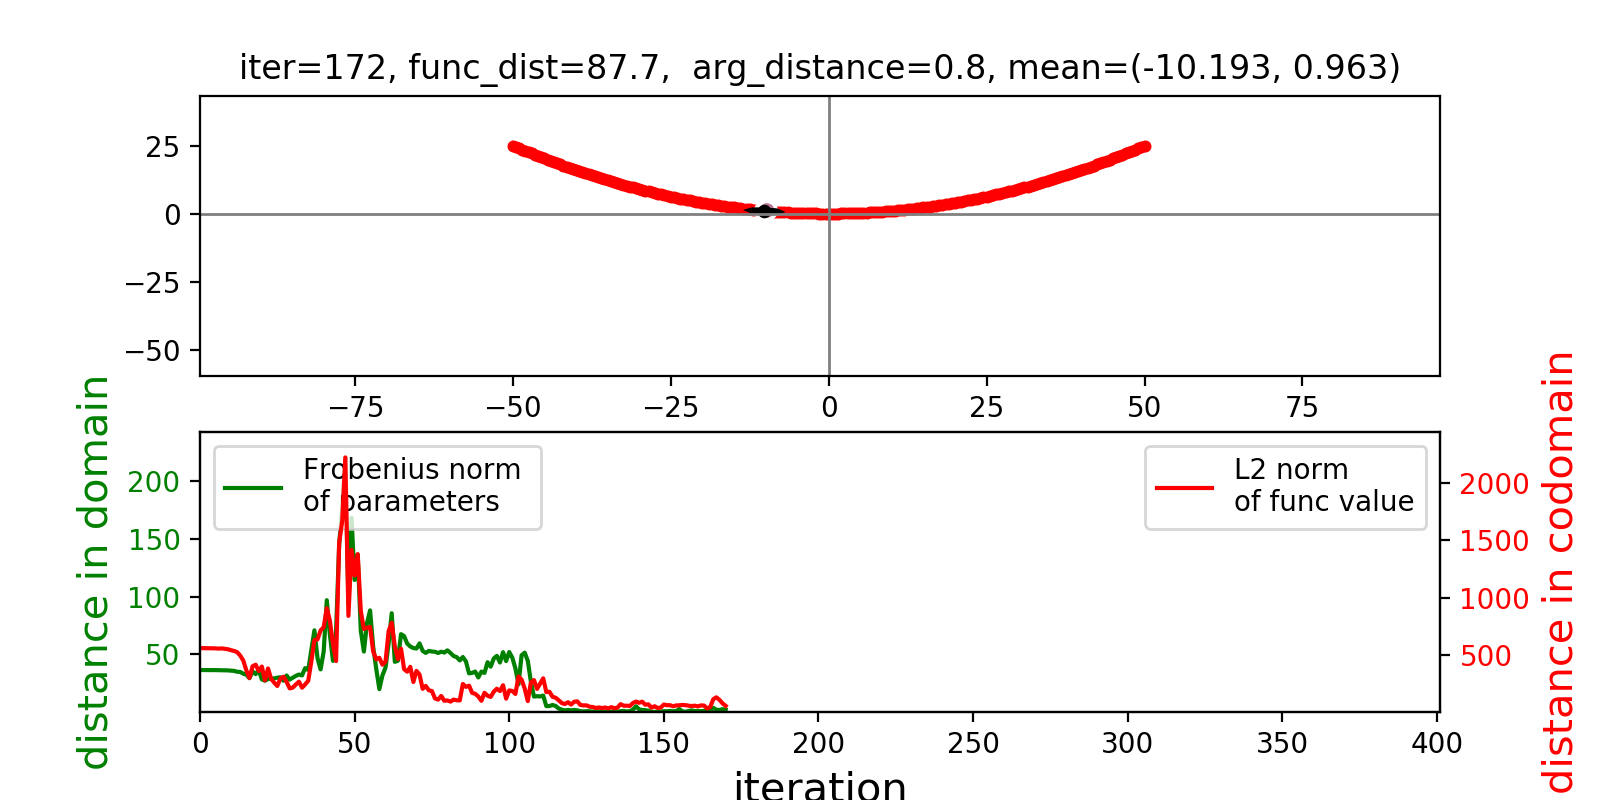

In [33]:
ex1.animate_scatterplot_distance()

## line search multple step

In [34]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
np.random.seed(101)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)

ex2 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, trail)
ex2.do_experiments(mean0, sigma, alpha, beta, line_search)

*******starting soon, intitial mean: ********
 [[-21.900]
 [10.000]]
Global minimum
eigenvalue of variance = [0.000 0.000]
min = 4.7224489335917496e-07, total iterations = 187, total evaluatios = 262359
 position = -10.000013894850127 1.000002778971956



In [38]:
val, arg, stats = ex2.get_recorded_data()

In [40]:
stats['x_adjust'][:10]

array([[[-19.193, -20.992, -21.249, -22.748, -23.918, -21.371],
        [10.628, 10.504, 9.681, 10.606, 10.740, 9.411],
        [-19.193, -20.992, -21.249, -22.748, -23.918, -21.371],
        [10.628, 10.504, 9.681, 10.606, 10.740, 9.411]],

       [[-21.899, -21.903, -21.899, -21.892, -21.899, -21.905],
        [9.998, 10.003, 10.006, 10.002, 10.005, 9.997],
        [-21.895, -21.898, -21.895, -21.888, -21.895, -21.901],
        [9.976, 9.981, 9.984, 9.980, 9.983, 9.975]],

       [[-21.896, -21.903, -21.917, -21.913, -21.888, -21.878],
        [9.966, 9.971, 9.973, 9.967, 9.994, 9.964],
        [-21.891, -21.898, -21.912, -21.908, -21.884, -21.874],
        [9.944, 9.949, 9.951, 9.945, 9.972, 9.942]],

       [[-21.899, -21.926, -21.831, -21.820, -21.987, -21.906],
        [9.775, 9.767, 9.929, 9.947, 9.961, 9.888],
        [-21.895, -21.922, -21.827, -21.816, -21.983, -21.901],
        [9.753, 9.744, 9.907, 9.925, 9.939, 9.866]],

       [[-22.423, -21.733, -21.947, -22.045, -21.693

<IPython.core.display.Javascript object>


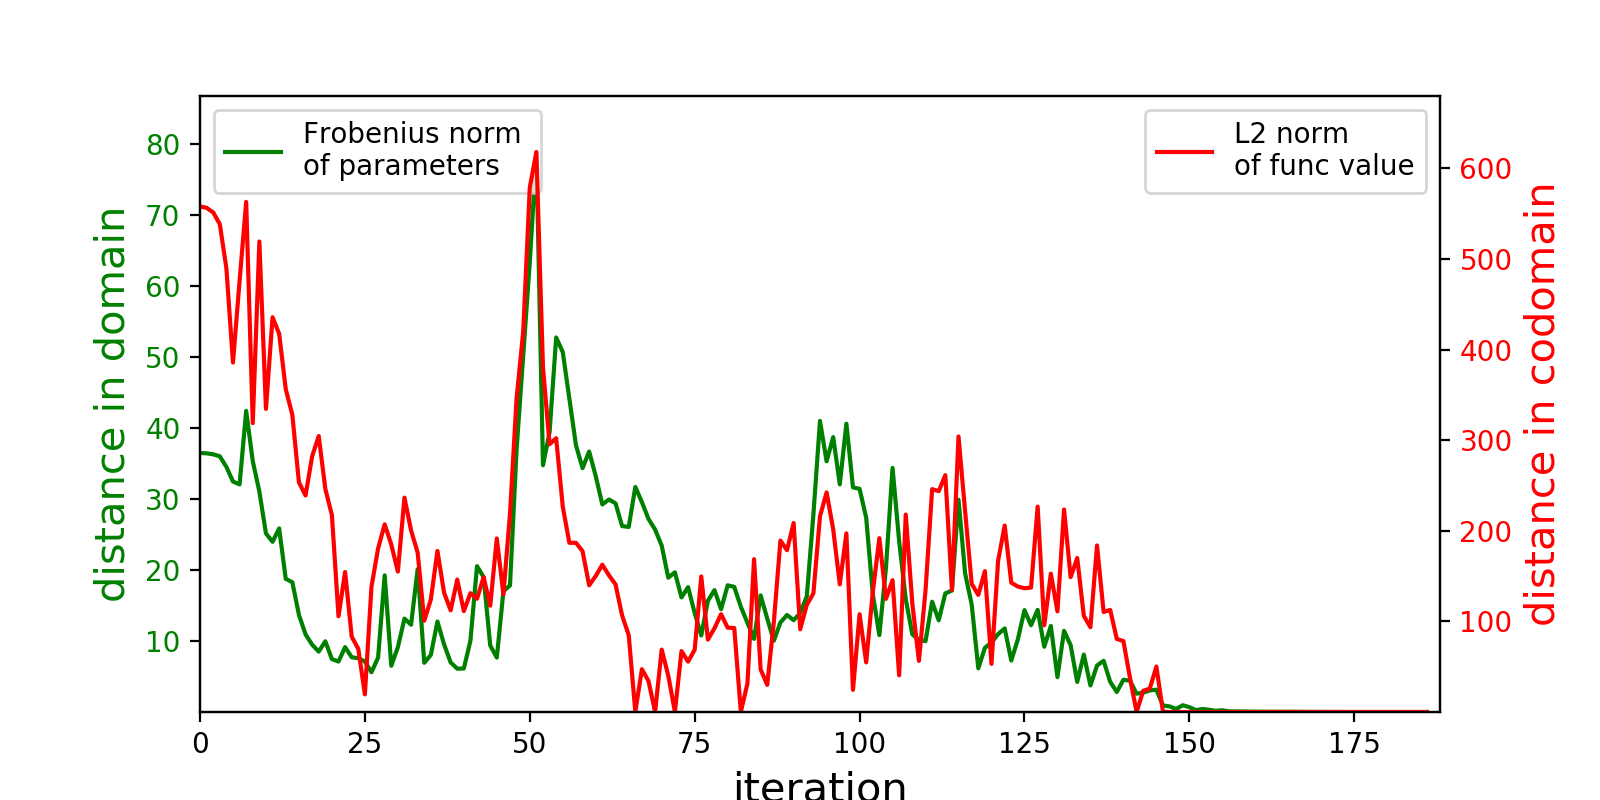

In [36]:
ex2.plot_distance()

<IPython.core.display.Javascript object>


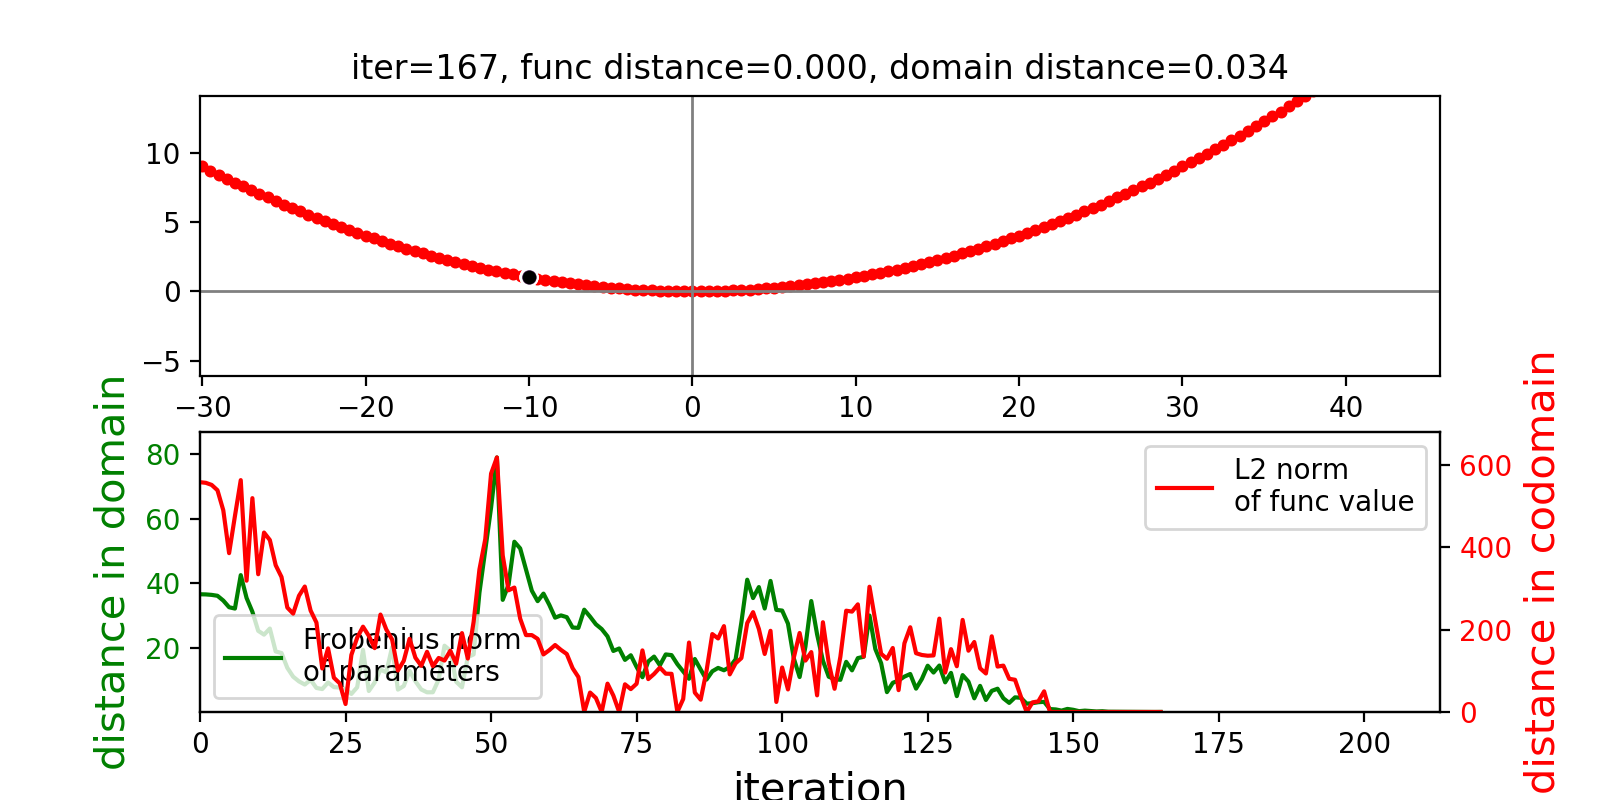

In [200]:
ex2.animate_scatterplot_distance()

## line search 1 step

In [13]:
mean0 = np.array([[-21.9],[10]])
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
np.random.seed(101)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)

ex3 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, trail)
ex3.do_experiments(mean0, sigma, alpha, beta, line_search_1step)

*******starting soon, intitial mean: ********
 [[-21.900]
 [10.000]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 0.14333296214658206, total iterations = 400, total evaluatios = 21218
 position = -0.019350416728935376 3.7862991672644057e-06



In [14]:
ex3.get_recorded_data()

(array([[220.198, 224.178, 227.391, 233.177, 247.034, 263.614],
        [228.110, 228.191, 228.271, 228.355, 228.355, 228.371],
        [228.077, 228.091, 228.146, 228.160, 228.200, 228.202],
        ...,
        [0.112, 0.123, 0.152, 0.181, 0.308, 0.332],
        [0.112, 0.129, 0.186, 0.201, 0.213, 0.223],
        [0.120, 0.123, 0.143, 0.163, 0.167, 0.275]]),
 array([[[-21.371, 9.411],
         [-23.918, 10.740],
         [-21.249, 9.681],
         [-22.748, 10.606],
         [-20.992, 10.504],
         [-19.193, 10.628]],
 
        [[-21.905, 9.996],
         [-21.899, 9.998],
         [-21.903, 10.003],
         [-21.892, 10.002],
         [-21.899, 10.005],
         [-21.899, 10.006]],
 
        [[-21.903, 9.994],
         [-21.907, 9.996],
         [-21.904, 9.998],
         [-21.903, 9.998],
         [-21.902, 9.999],
         [-21.901, 9.999]],
 
        ...,
 
        [[-0.014, 0.000],
         [-0.020, 0.000],
         [0.002, -0.000],
         [-0.013, 0.000],
         [-0.03

<IPython.core.display.Javascript object>


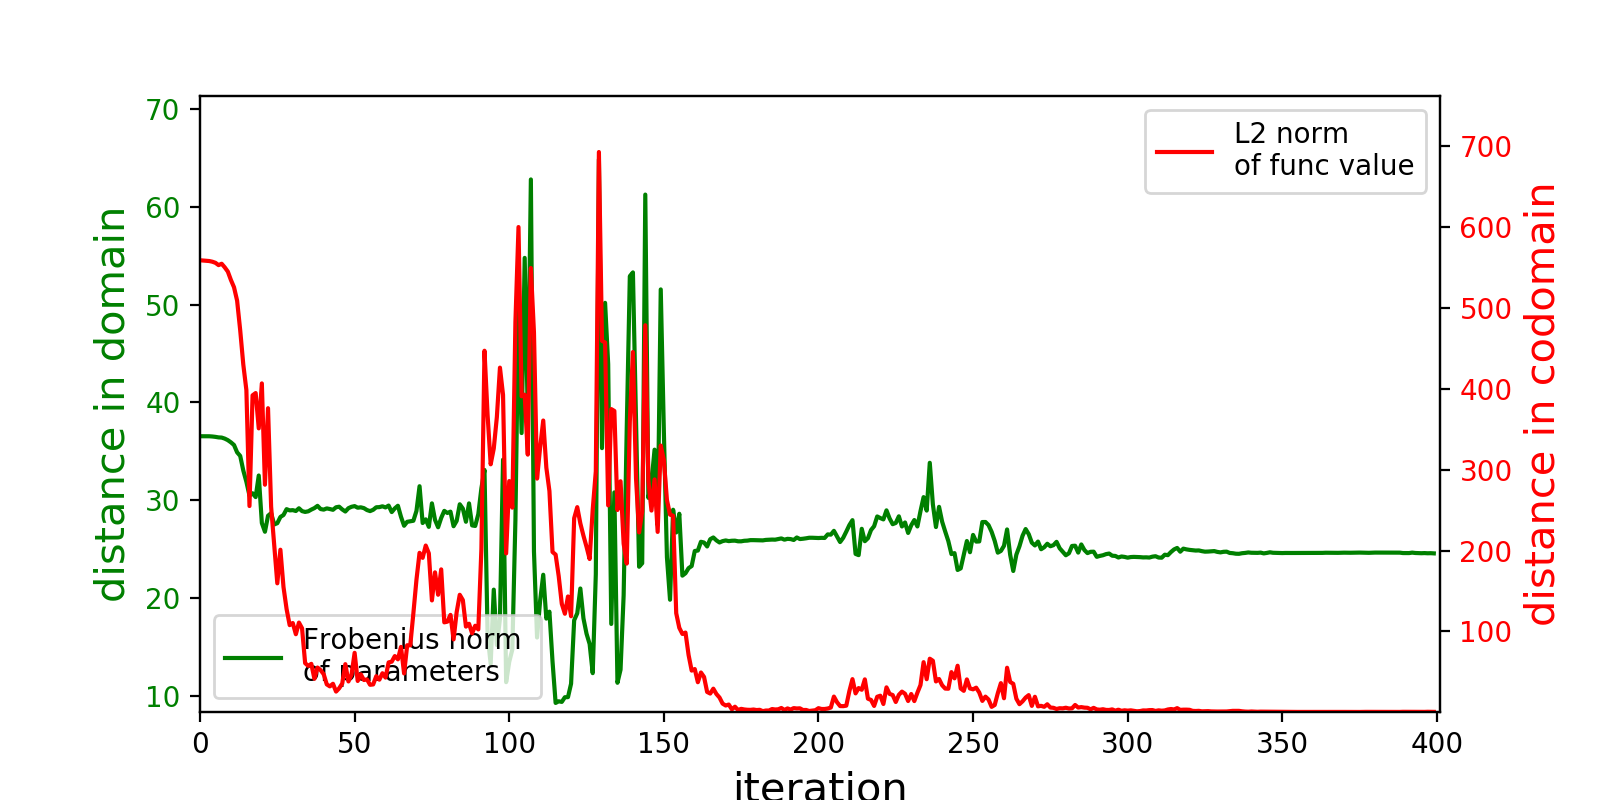

In [137]:
ex3.plot_distance()

<IPython.core.display.Javascript object>


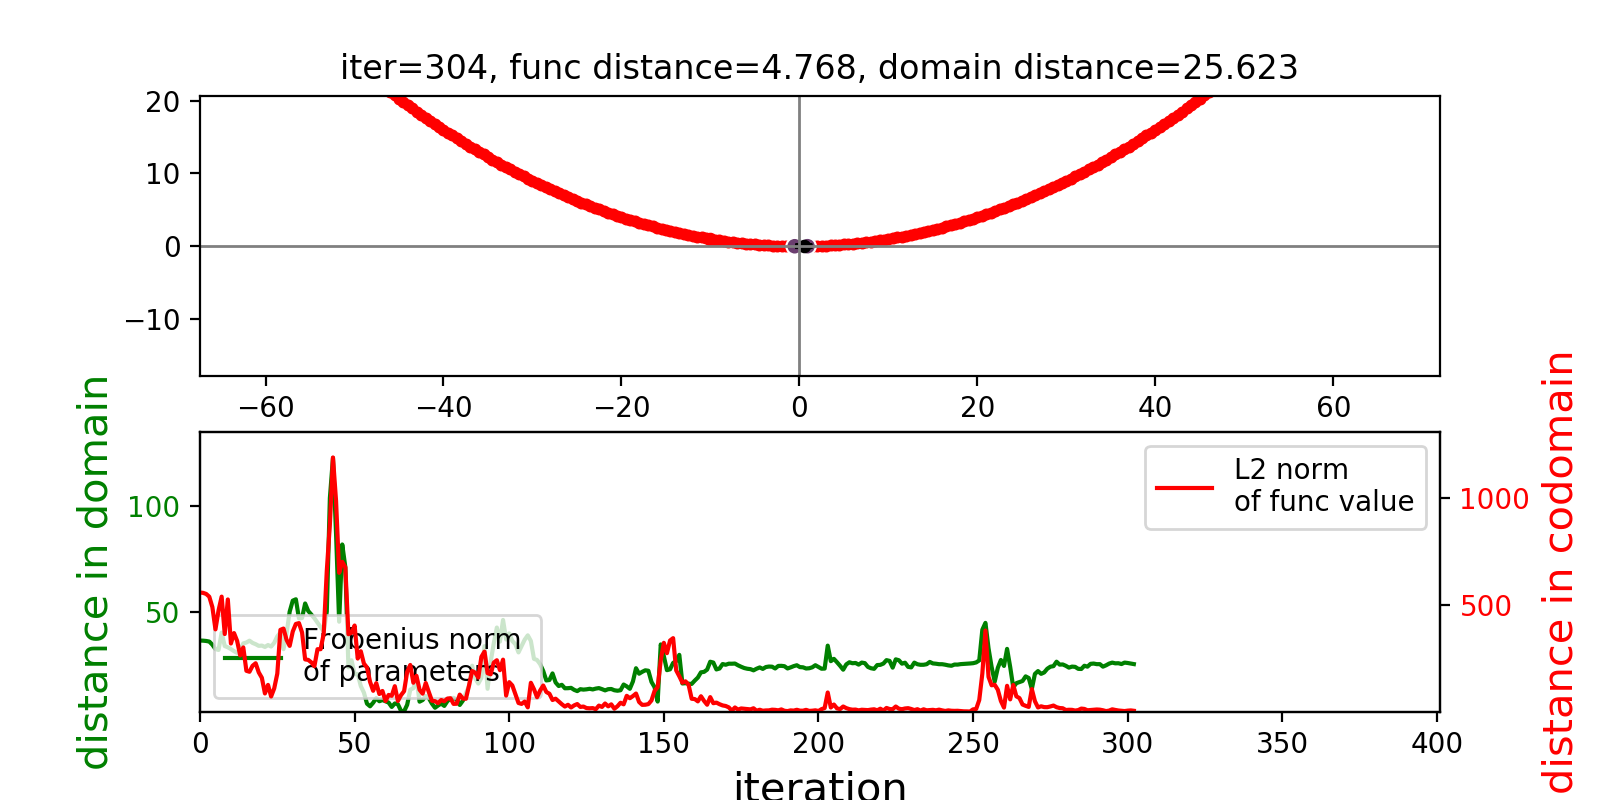

In [120]:
ex3.animate_scatterplot_distance()

In [ ]:

ex2 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, trail)
ex2.generate_point_cloud(sigma, alpha, beta, line_search, points)

<IPython.core.display.Javascript object>


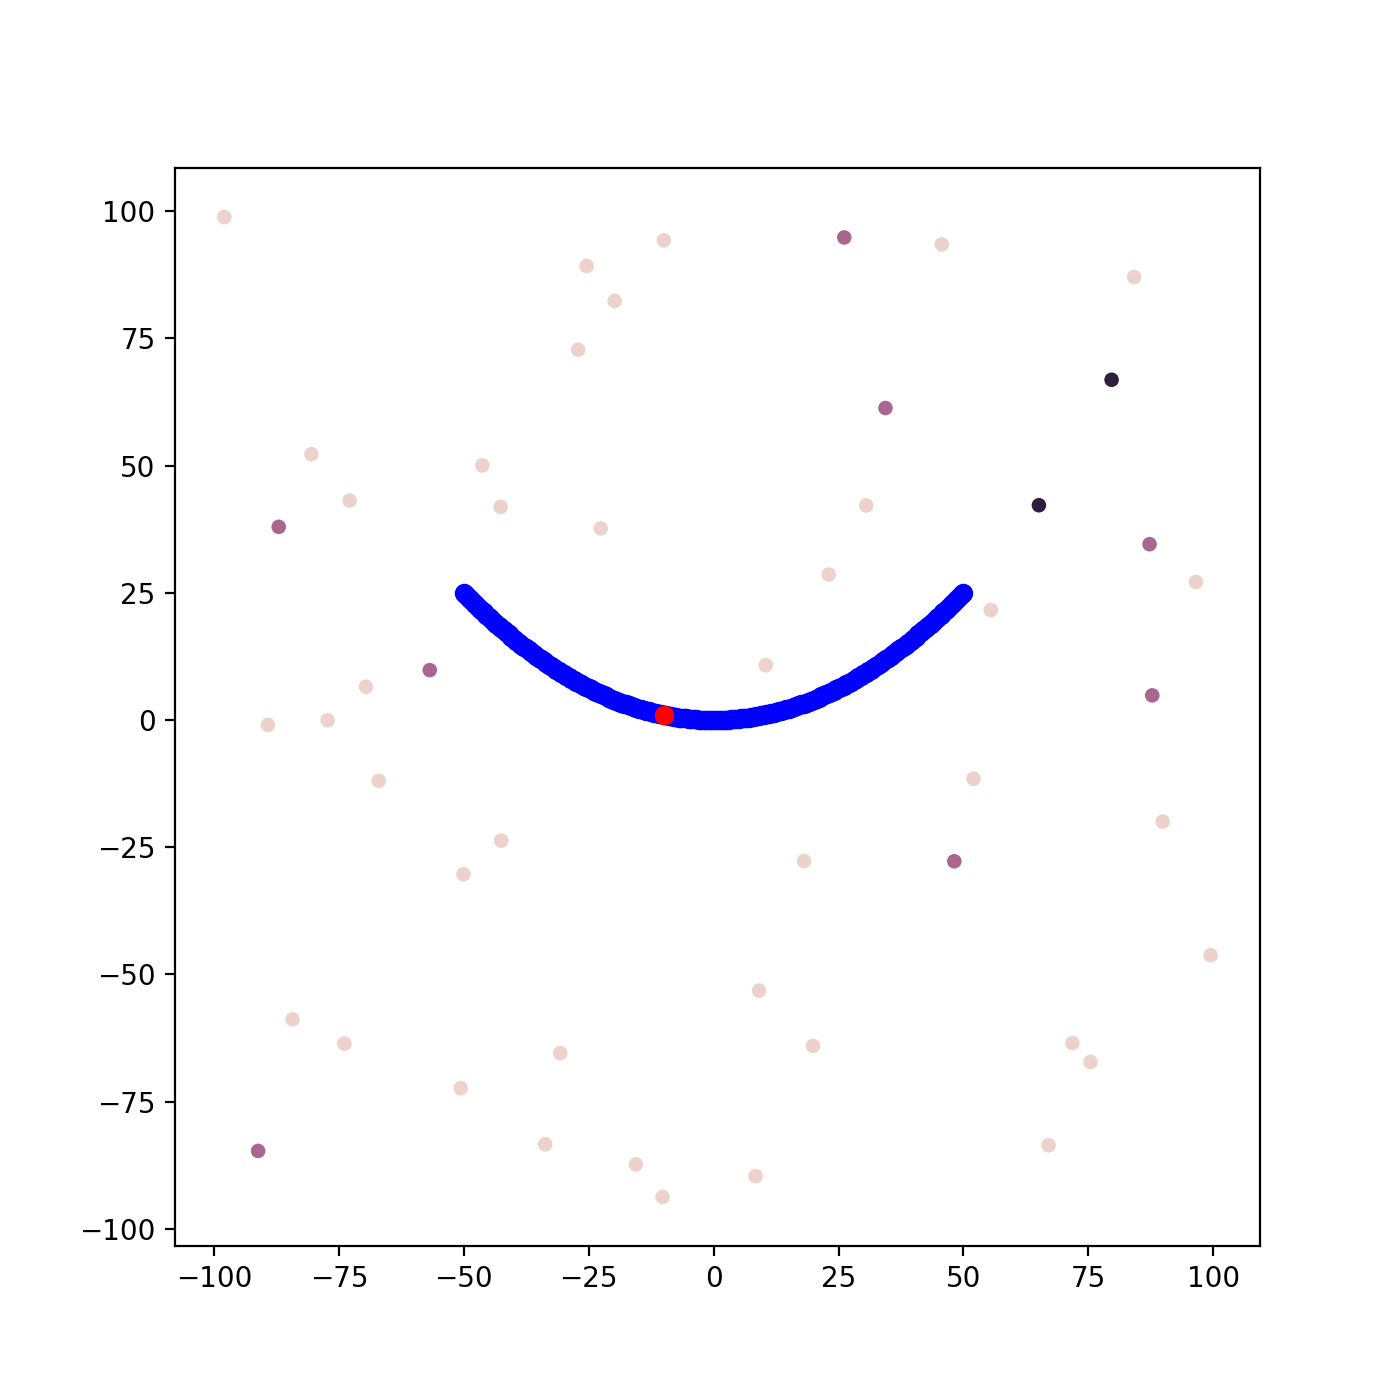

In [196]:
ex2.plot_cloud_point()
plt.scatter(trail[0], trail[1], c = 'blue')
plt.scatter(-10, 1, c = 'red')

In [16]:
res, points = ex2.get_results_points()
print("prob of global convergence", np.sum(res == 0) / res.shape[0])

prob of global convergence 0.6666666666666666


In [14]:
np.random.seed(19)
sigma = np.ones((2,)) * 0.003
alpha = 0.00001
beta = 0.00002
np.random.seed(11)
optimal_trail = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = optimal_trail(x)
trail = (x, y)

points = random_initial_mean(np.array([100,100]),  np.array([0, 0]), 3)
ex2 = non_convex_optimisation(bukin, d_bukin, np.array([-10,1]), 0, trail)
ex2.generate_point_cloud(sigma, alpha, beta, line_search, points)

*******starting soon, intitial mean: ********
 [[-63.946]
 [-96.105]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 0.13542778736959574, total iterations = 400, total evaluatios = 538989
 position = -2.4209122079953658 0.05860815918820997

*******starting soon, intitial mean: ********
 [[-7.356]
 [44.987]]
Global minimum
eigenvalue of variance = [0.000 0.000]
min = 4.6254066807804863e-07, total iterations = 326, total evaluatios = 437554
 position = -9.999953745933192 0.9999907492080329

*******starting soon, intitial mean: ********
 [[-15.959]
 [-2.915]]
Global minimum
eigenvalue of variance = [0.000 0.000]
min = 7.824766413655482e-07, total iterations = 312, total evaluatios = 430730
 position = -10.000052174882464 1.0000104350037151



<IPython.core.display.Javascript object>


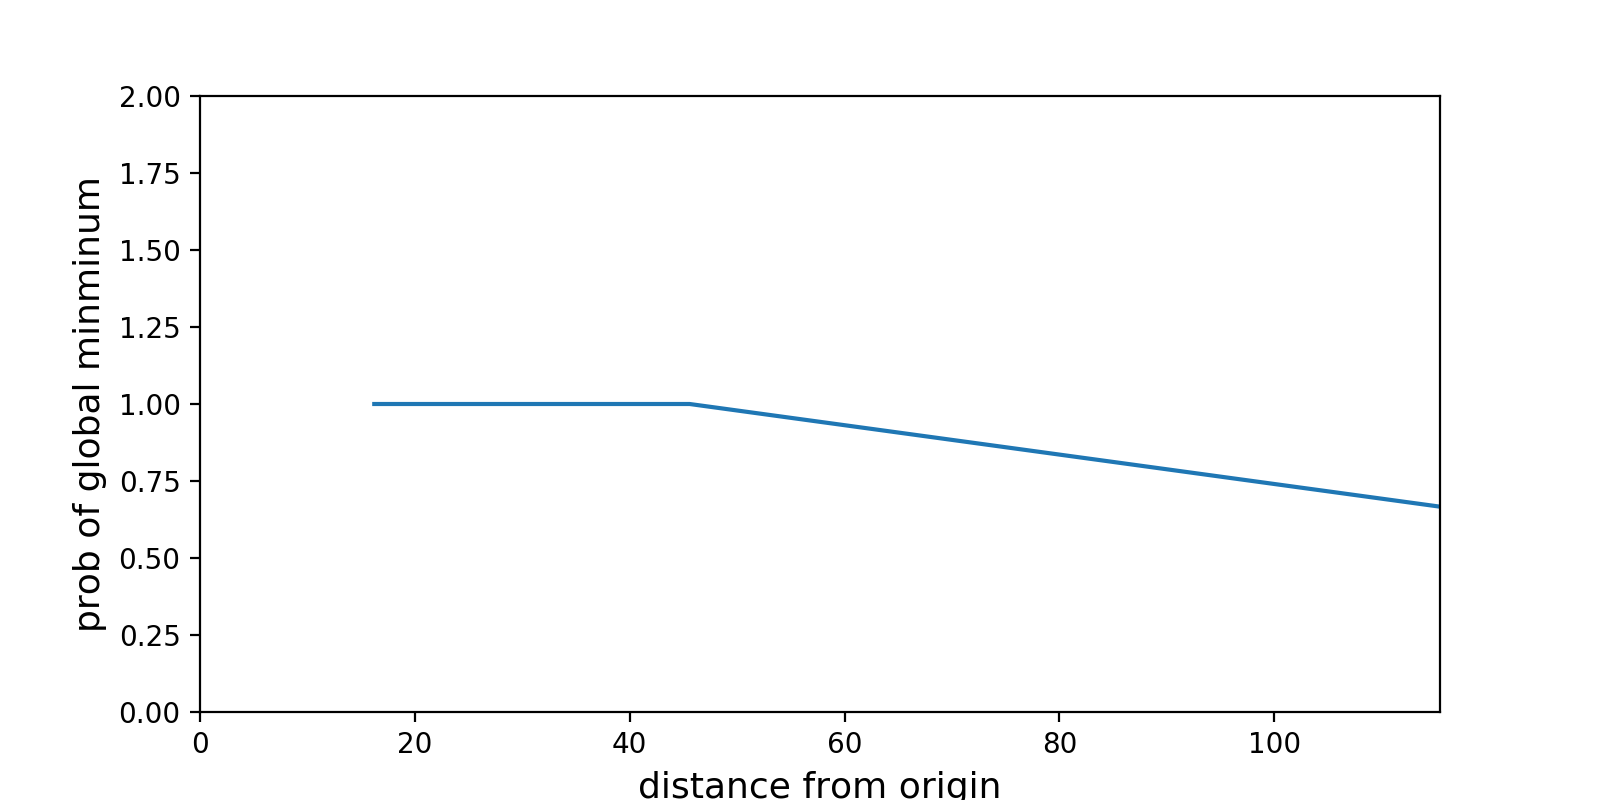

In [15]:
ex2.plot_prob_vs_radius()